# Рекомендация тарифов для клиентов телеком оператора

В нашем распоряжении есть данные о поведении клиентов телеком оператора, которые пользуются тарифами Smart и Ultra. 

Построим модель для задачи классификации. Модель должна предлагать определенный тариф.

При выборе модели будем оценивать значение *accuracy*. Доля правильных ответов должна превышать 0.75.

## Изучение данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
#откроем файл и просмотрим первые строки
df = pd.read_csv('users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


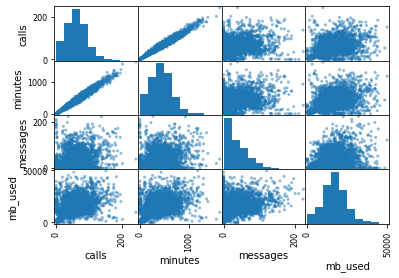

In [3]:
#посмотрим, как признаки в датасете коррелируют между собой
pd.plotting.scatter_matrix(df[['calls', 'minutes', 'messages', 'mb_used']]);

Заметна прямая линейная взаимосвязь между количеством звонков и количеством использованных минут. Это логично: каждый звонок увеличивает сумму использованных минут. 

Это значит, что в данных наблюдается мультиколлинеарность, что усложняет модель и может привести к переобучению. Лучше удалить один из этих признаков.

Оставим в датасете минуты: звонки могут быть как очень короткими, так и очень длинными, а тарификация осуществляется по минутам. В нашем случае количество использованных минут - более надежный признак.

In [4]:
#сохраним в отдельных переменных датасет без целевого признака (features) и целевой признак (target)
features = df.drop(['is_ultra', 'calls'], axis = 1)
target = df['is_ultra']

In [5]:
#количество объектов - 3214
len(target)

3214

In [6]:
#тарифом Ultra пользуются 30% абонентов в нашем датасете 
target.mean()

0.30647168637212197

## Разделение данных на выборки

In [7]:
#сначала выделим тестовую выборку (20%)
features_new, features_test, target_new, target_test = train_test_split(features, target, \
                                                        test_size=0.2, random_state=12345)

#теперь оставшиеся данные разделим на тренировочный и валидационный наборы данных
#20% исходного датасета - это 25% нового датасета, который получился после исключения тестовой выборки
features_train, features_valid, target_train, target_valid = train_test_split(features_new, target_new,\
                                                            test_size=0.25, random_state=12345)

#проверим, что соотношение тренировочной, валидационной и тестовой выборок - 3/1/1
print('Доля объектов в обучающей выборке:', round((len(features_train) / len(features)), 2))
print('Доля объектов в валидационной выборке:', round((len(features_valid) / len(features)), 2))
print('Доля объектов в тестовой выборке:', round((len(features_test) / len(features)), 2))

Доля объектов в обучающей выборке: 0.6
Доля объектов в валидационной выборке: 0.2
Доля объектов в тестовой выборке: 0.2


## Построение и сравнение моделей

### Дерево решений

In [8]:
#обучим дерево решений, протестируем максимальную глубину от 1 до 10 и выберем наилучший вариант
best_dt_model = None
best_dt_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=123, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    if result > best_dt_result:
        best_dt_model = model
        best_dt_result = result
print("Accuracy наилучшей модели дерева решений на валидационной выборке:", best_dt_result)

Accuracy наилучшей модели дерева решений на валидационной выборке: 0.7713841368584758


### Случайный лес

In [9]:
#обучим случайный лес, протестируем количество деревьев от 1 до 10 и выберем наилучший вариант
best_rf_model = None
best_rf_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=123, n_estimators=est)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_rf_result:
        best_rf_model = model
        best_rf_result = result
print("Accuracy наилучшей модели случайного леса на валидационной выборке:", best_rf_result)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.7869362363919129


### Логистическая регрессия

In [10]:
#обучим модель логистической регрессии
lr_model = LogisticRegression(solver = 'lbfgs', random_state=123)
lr_model.fit(features_train, target_train)
lr_result = lr_model.score(features_valid, target_valid)

print("Accuracy модели логистической регрессии на валидационной выборке:", lr_result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7262830482115086


### Выбор и проверка модели

Наилучший результат на валидационной выборке продемонстрировала модель случайного леса. 

Проверим модель на тестовой выборке:

In [11]:
rf_test = best_rf_model.score(features_test, target_test)
print('Accuracy наилучшей модели случайного леса на тестовой выборке:', rf_test)

Accuracy наилучшей модели случайного леса на тестовой выборке: 0.7807153965785381


Результат на тестовой выборке хуже, чем на валидационной выборке. Попробуем улучшить модель.

## Улучшение модели

Попробуем использовать разные гиперпараметры, чтобы улучшить результат на валидационной и тестовой выборках:

In [12]:
#ограничим минимальное количество объектов для разделения и минимальное количество объектов в листах
best_rf_model = None
best_rf_result = 0
for est in range(1, 11):
    model = RandomForestClassifier(random_state=123, n_estimators=est, \
                                  min_samples_split = 15, min_samples_leaf = 10)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_rf_result:
        best_rf_model = model
        best_rf_result = result
print("Accuracy наилучшей модели на валидационной выборке:", best_rf_result)

rf_test = best_rf_model.score(features_test, target_test)
print('Accuracy наилучшей модели на тестовой выборке:', rf_test)

Accuracy наилучшей модели на валидационной выборке: 0.7822706065318819
Accuracy наилучшей модели на тестовой выборке: 0.8009331259720062


In [13]:
#увеличим количество деревьев
best_rf_model = None
best_rf_result = 0
for est in range(1, 101, 10):
    model = RandomForestClassifier(random_state=123, n_estimators=est, \
                                  min_samples_split = 15, min_samples_leaf = 10)
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_rf_result:
        best_rf_model = model
        best_rf_result = result
print("Accuracy наилучшей модели на валидационной выборке:", best_rf_result)

rf_test = best_rf_model.score(features_test, target_test)
print('Accuracy наилучшей модели случайного леса на тестовой выборке:', rf_test)

Accuracy наилучшей модели на валидационной выборке: 0.7916018662519441
Accuracy наилучшей модели случайного леса на тестовой выборке: 0.8040435458786936


Теперь модель правильно рекомендует тариф **почти в 80% случаев**.

## Проверка модели на адекватность

Проверим нашу модель на вменяемость. Для этого сравним работу нашей обученной модели со случайными рекомендациями тарифа. 

Мы знаем, что 30% абонентов из нашего датасета пользуются тарифом Ultra, а остальные - Smart. Сгенерируем случайные рекомендации: в 30% случаев порекомендуем тариф Ultra, и в 70% случаев - тариф Smart.

In [14]:
#уточним размер валидационной выборки
len(target_valid)

643

In [15]:
#на всякий случай проверим, что размер тестовой выборки такой же
len(target_test)

643

In [16]:
#предсказание, сделанное случайным образом, сохраним в переменную pred
np.random.seed(123)
pred = pd.Series(np.random.choice([0, 1], size=643, p=[0.69, 0.31]))

#проверим, что у нас получилось 30% рекомендаций тарифа Ultra и 70% - тарифа Smart
pred.value_counts(normalize = True)

0    0.699844
1    0.300156
dtype: float64

In [17]:
#посмотрим, с каким accuracy случайные рекомендации попали в цель
print('Accuracy случайных рекомендаций на валидационной выборке:', accuracy_score(target_valid, pred))
print('Accuracy случайных рекомендаций на тестовой выборке:', accuracy_score(target_test, pred))

Accuracy случайных рекомендаций на валидационной выборке: 0.5660964230171073
Accuracy случайных рекомендаций на тестовой выборке: 0.6034214618973561


Доля попаданий случайных рекомендаций — в лучшем случае 60%, а наша обученная модель справляется с задачей почти в 80% случаев. Проверка на вменяемость модели успешно пройдена.

## Выводы

Построили модель, которая успешно рекомендует подходящий тариф почти в 80% случаев.

- подготовили данные для обучения модели, выделили признаки и целевой признак


- разделили датасет на обучающую выборку, валидационную и тестовую выборки (в соотношении 3:1:1)


- обучили 3 модели: дерево решений, случайный лес и логистическую регрессию


- выбрали модель с наилучшим accuracy на валидационной выборке: случайный лес


- изменили гиперпараметры, что позволило увеличить accuracy на валидационной и тестовой выборках почти до 80%


- провели успешную проверку модели на вменяемость: наша модель справляется гораздо лучше, чем случайные рекомендации одного из двух тарифов (accuracy почти 80% против 60% у случайных рекомендаций).